In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [2]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


# Get Data Spectra

In [72]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (wdtable['centre_beta'] < hbeta + 5)*
    (wdtable['centre_beta'] > hbeta - 5)*
    (wdtable['centre_alpha'] > halpha - 5)*
    (wdtable['centre_alpha'] < halpha + 5) * 
    (~np.isnan(wdtable['loggH']))*
    (~np.isnan(wdtable['TeffH']))*
    (wdtable['TeffH'] > 13000) * 
    (wdtable['TeffH'] < 80000) * 
    (wdtable['subclass'] == 'WD')[:,0].data*
    (wdtable['S2N'] > 1)
)
notgoodtable = wdtable[~good]
wdtable = wdtable[good]
len(wdtable)

1518

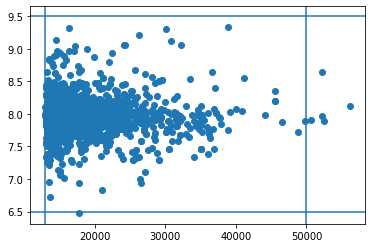

In [73]:
plt.scatter(wdtable['TeffH'],wdtable['loggH'])
plt.axhline(6.5)
plt.axhline(9.5)
plt.axvline(13000)
plt.axvline(50000)

In [74]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

# def rvcorr(spectrum):
#     lamgrid = np.arange(4000,8000)
#     coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
#     coremask = coremask.astype(int)
#     trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
#     if trans > 5:
#         trans = 5;
#     elif trans < 5:
#         trans = -5;
#     else:
#         ;
#     shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
#     return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

100%|██████████| 1518/1518 [02:17<00:00, 11.39it/s]


In [75]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [186]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)









  0%|          | 0/1518 [00:00<?, ?it/s]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2950 but corresponding boolean dimension is 4000

In [189]:
newspec = [];
for i in range(len(spectra)):
    newspec.append(spectra[i][50:3000])
    
newspec = np.asarray(newspec)

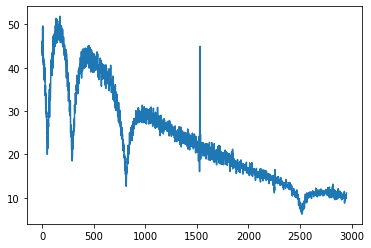

In [190]:
plt.plot(newspec[2])

# Train Generator

In [191]:
sc = StandardScaler()
msc = StandardScaler()
X = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())
t = msc.fit_transform(newspec)
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1,random_state=13)

In [192]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(32,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(32,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(t[0].shape[0],activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                96        
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 2950)              97350     
Total params: 98,502
Trainable params: 98,502
Non-trainable params: 0
_________________________________________________________________
None


In [196]:
epoch = 1000
batch = len(X_train)

history = model.fit(X_train,y_train,epochs=epoch,verbose=2,batch_size=batch,validation_data = (X_test,y_test))

Train on 1366 samples, validate on 152 samples
Epoch 1/1000
 - 0s - loss: 0.8892 - mean_absolute_percentage_error: 393.1717 - val_loss: 1.1020 - val_mean_absolute_percentage_error: 302.7099
Epoch 2/1000
 - 0s - loss: 0.8679 - mean_absolute_percentage_error: 471.8435 - val_loss: 1.1020 - val_mean_absolute_percentage_error: 302.6391
Epoch 3/1000
 - 0s - loss: 0.8724 - mean_absolute_percentage_error: 458.8099 - val_loss: 1.1020 - val_mean_absolute_percentage_error: 302.5956
Epoch 4/1000
 - 0s - loss: 0.8599 - mean_absolute_percentage_error: 435.0644 - val_loss: 1.1020 - val_mean_absolute_percentage_error: 302.3858
Epoch 5/1000
 - 0s - loss: 0.8833 - mean_absolute_percentage_error: 449.4911 - val_loss: 1.1019 - val_mean_absolute_percentage_error: 302.0932
Epoch 6/1000
 - 0s - loss: 0.8888 - mean_absolute_percentage_error: 490.6388 - val_loss: 1.1019 - val_mean_absolute_percentage_error: 301.6687
Epoch 7/1000
 - 0s - loss: 0.9001 - mean_absolute_percentage_error: 550.9836 - val_loss: 1.1019

Epoch 58/1000
 - 0s - loss: 0.8963 - mean_absolute_percentage_error: 460.6170 - val_loss: 1.1004 - val_mean_absolute_percentage_error: 299.8961
Epoch 59/1000
 - 0s - loss: 0.8833 - mean_absolute_percentage_error: 503.8391 - val_loss: 1.1004 - val_mean_absolute_percentage_error: 299.6911
Epoch 60/1000
 - 0s - loss: 0.8757 - mean_absolute_percentage_error: 555.9284 - val_loss: 1.1005 - val_mean_absolute_percentage_error: 299.4757
Epoch 61/1000
 - 0s - loss: 0.8701 - mean_absolute_percentage_error: 487.8802 - val_loss: 1.1005 - val_mean_absolute_percentage_error: 299.4384
Epoch 62/1000
 - 0s - loss: 0.8830 - mean_absolute_percentage_error: 515.5101 - val_loss: 1.1005 - val_mean_absolute_percentage_error: 299.7341
Epoch 63/1000
 - 0s - loss: 0.8852 - mean_absolute_percentage_error: 512.8279 - val_loss: 1.1005 - val_mean_absolute_percentage_error: 299.6262
Epoch 64/1000
 - 0s - loss: 0.8832 - mean_absolute_percentage_error: 485.6394 - val_loss: 1.1005 - val_mean_absolute_percentage_error: 2

Epoch 115/1000
 - 0s - loss: 0.8844 - mean_absolute_percentage_error: 449.5513 - val_loss: 1.0998 - val_mean_absolute_percentage_error: 298.7798
Epoch 116/1000
 - 0s - loss: 0.8989 - mean_absolute_percentage_error: 425.9966 - val_loss: 1.0998 - val_mean_absolute_percentage_error: 298.7987
Epoch 117/1000
 - 0s - loss: 0.8853 - mean_absolute_percentage_error: 444.8200 - val_loss: 1.0999 - val_mean_absolute_percentage_error: 298.7148
Epoch 118/1000
 - 0s - loss: 0.8603 - mean_absolute_percentage_error: 469.0028 - val_loss: 1.0999 - val_mean_absolute_percentage_error: 298.5404
Epoch 119/1000
 - 0s - loss: 0.8766 - mean_absolute_percentage_error: 476.8993 - val_loss: 1.0999 - val_mean_absolute_percentage_error: 298.4396
Epoch 120/1000
 - 0s - loss: 0.8809 - mean_absolute_percentage_error: 448.2551 - val_loss: 1.1000 - val_mean_absolute_percentage_error: 298.4154
Epoch 121/1000
 - 0s - loss: 0.8820 - mean_absolute_percentage_error: 472.6634 - val_loss: 1.1000 - val_mean_absolute_percentage_e

Epoch 172/1000
 - 0s - loss: 0.8710 - mean_absolute_percentage_error: 471.0532 - val_loss: 1.0996 - val_mean_absolute_percentage_error: 295.5214
Epoch 173/1000
 - 0s - loss: 0.8622 - mean_absolute_percentage_error: 464.0081 - val_loss: 1.0995 - val_mean_absolute_percentage_error: 294.9863
Epoch 174/1000
 - 0s - loss: 0.8748 - mean_absolute_percentage_error: 410.1017 - val_loss: 1.0995 - val_mean_absolute_percentage_error: 294.5739
Epoch 175/1000
 - 0s - loss: 0.8863 - mean_absolute_percentage_error: 426.1963 - val_loss: 1.0995 - val_mean_absolute_percentage_error: 294.1684
Epoch 176/1000
 - 0s - loss: 0.8737 - mean_absolute_percentage_error: 408.9197 - val_loss: 1.0995 - val_mean_absolute_percentage_error: 293.8438
Epoch 177/1000
 - 0s - loss: 0.8824 - mean_absolute_percentage_error: 463.9755 - val_loss: 1.0995 - val_mean_absolute_percentage_error: 293.4034
Epoch 178/1000
 - 0s - loss: 0.8846 - mean_absolute_percentage_error: 451.6664 - val_loss: 1.0995 - val_mean_absolute_percentage_e

Epoch 229/1000
 - 0s - loss: 0.8897 - mean_absolute_percentage_error: 471.9425 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 293.3940
Epoch 230/1000
 - 0s - loss: 0.8813 - mean_absolute_percentage_error: 453.9600 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 293.4146
Epoch 231/1000
 - 0s - loss: 0.8799 - mean_absolute_percentage_error: 396.2471 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 293.3893
Epoch 232/1000
 - 0s - loss: 0.8681 - mean_absolute_percentage_error: 432.7617 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 293.5016
Epoch 233/1000
 - 0s - loss: 0.8662 - mean_absolute_percentage_error: 456.5062 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 293.6219
Epoch 234/1000
 - 0s - loss: 0.8672 - mean_absolute_percentage_error: 428.4607 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 293.6834
Epoch 235/1000
 - 0s - loss: 0.8800 - mean_absolute_percentage_error: 450.1972 - val_loss: 1.0990 - val_mean_absolute_percentage_e

Epoch 286/1000
 - 0s - loss: 0.8686 - mean_absolute_percentage_error: 434.2834 - val_loss: 1.0990 - val_mean_absolute_percentage_error: 286.8835
Epoch 287/1000
 - 0s - loss: 0.8666 - mean_absolute_percentage_error: 450.2727 - val_loss: 1.0990 - val_mean_absolute_percentage_error: 287.0944
Epoch 288/1000
 - 0s - loss: 0.8797 - mean_absolute_percentage_error: 402.1222 - val_loss: 1.0990 - val_mean_absolute_percentage_error: 287.6257
Epoch 289/1000
 - 0s - loss: 0.8926 - mean_absolute_percentage_error: 497.2816 - val_loss: 1.0990 - val_mean_absolute_percentage_error: 288.3236
Epoch 290/1000
 - 0s - loss: 0.9033 - mean_absolute_percentage_error: 474.4706 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 288.8382
Epoch 291/1000
 - 0s - loss: 0.8827 - mean_absolute_percentage_error: 420.3187 - val_loss: 1.0991 - val_mean_absolute_percentage_error: 289.5283
Epoch 292/1000
 - 0s - loss: 0.8707 - mean_absolute_percentage_error: 418.1721 - val_loss: 1.0991 - val_mean_absolute_percentage_e

Epoch 343/1000
 - 0s - loss: 0.8683 - mean_absolute_percentage_error: 498.6279 - val_loss: 1.0980 - val_mean_absolute_percentage_error: 293.9615
Epoch 344/1000
 - 0s - loss: 0.8700 - mean_absolute_percentage_error: 468.4086 - val_loss: 1.0980 - val_mean_absolute_percentage_error: 293.7553
Epoch 345/1000
 - 0s - loss: 0.8795 - mean_absolute_percentage_error: 459.8487 - val_loss: 1.0980 - val_mean_absolute_percentage_error: 293.1458
Epoch 346/1000
 - 0s - loss: 0.8502 - mean_absolute_percentage_error: 455.9857 - val_loss: 1.0979 - val_mean_absolute_percentage_error: 292.4476
Epoch 347/1000
 - 0s - loss: 0.8788 - mean_absolute_percentage_error: 479.3948 - val_loss: 1.0979 - val_mean_absolute_percentage_error: 291.7777
Epoch 348/1000
 - 0s - loss: 0.8843 - mean_absolute_percentage_error: 446.2122 - val_loss: 1.0979 - val_mean_absolute_percentage_error: 291.1994
Epoch 349/1000
 - 0s - loss: 0.8762 - mean_absolute_percentage_error: 454.6181 - val_loss: 1.0979 - val_mean_absolute_percentage_e

Epoch 400/1000
 - 0s - loss: 0.8840 - mean_absolute_percentage_error: 454.5345 - val_loss: 1.0978 - val_mean_absolute_percentage_error: 287.8978
Epoch 401/1000
 - 0s - loss: 0.8799 - mean_absolute_percentage_error: 464.9514 - val_loss: 1.0978 - val_mean_absolute_percentage_error: 287.3277
Epoch 402/1000
 - 0s - loss: 0.8817 - mean_absolute_percentage_error: 479.8681 - val_loss: 1.0977 - val_mean_absolute_percentage_error: 286.9405
Epoch 403/1000
 - 0s - loss: 0.8842 - mean_absolute_percentage_error: 461.2349 - val_loss: 1.0977 - val_mean_absolute_percentage_error: 286.5005
Epoch 404/1000
 - 0s - loss: 0.8782 - mean_absolute_percentage_error: 453.6159 - val_loss: 1.0978 - val_mean_absolute_percentage_error: 286.0950
Epoch 405/1000
 - 0s - loss: 0.8745 - mean_absolute_percentage_error: 424.1964 - val_loss: 1.0978 - val_mean_absolute_percentage_error: 285.6987
Epoch 406/1000
 - 0s - loss: 0.8898 - mean_absolute_percentage_error: 469.3706 - val_loss: 1.0978 - val_mean_absolute_percentage_e

Epoch 457/1000
 - 0s - loss: 0.8648 - mean_absolute_percentage_error: 433.1596 - val_loss: 1.0970 - val_mean_absolute_percentage_error: 286.4383
Epoch 458/1000
 - 0s - loss: 0.8797 - mean_absolute_percentage_error: 459.4988 - val_loss: 1.0969 - val_mean_absolute_percentage_error: 287.2500
Epoch 459/1000
 - 0s - loss: 0.8613 - mean_absolute_percentage_error: 473.4256 - val_loss: 1.0969 - val_mean_absolute_percentage_error: 288.0871
Epoch 460/1000
 - 0s - loss: 0.8831 - mean_absolute_percentage_error: 436.4483 - val_loss: 1.0968 - val_mean_absolute_percentage_error: 288.6286
Epoch 461/1000
 - 0s - loss: 0.8808 - mean_absolute_percentage_error: 492.2175 - val_loss: 1.0968 - val_mean_absolute_percentage_error: 288.9995
Epoch 462/1000
 - 0s - loss: 0.8871 - mean_absolute_percentage_error: 484.7540 - val_loss: 1.0968 - val_mean_absolute_percentage_error: 289.1563
Epoch 463/1000
 - 0s - loss: 0.8681 - mean_absolute_percentage_error: 512.0698 - val_loss: 1.0968 - val_mean_absolute_percentage_e

Epoch 514/1000
 - 0s - loss: 0.8766 - mean_absolute_percentage_error: 480.9935 - val_loss: 1.0973 - val_mean_absolute_percentage_error: 287.8474
Epoch 515/1000
 - 0s - loss: 0.8844 - mean_absolute_percentage_error: 520.2216 - val_loss: 1.0973 - val_mean_absolute_percentage_error: 287.5489
Epoch 516/1000
 - 0s - loss: 0.8875 - mean_absolute_percentage_error: 450.8161 - val_loss: 1.0973 - val_mean_absolute_percentage_error: 287.2650
Epoch 517/1000
 - 0s - loss: 0.8753 - mean_absolute_percentage_error: 437.4054 - val_loss: 1.0973 - val_mean_absolute_percentage_error: 286.7909
Epoch 518/1000
 - 0s - loss: 0.8765 - mean_absolute_percentage_error: 444.1178 - val_loss: 1.0973 - val_mean_absolute_percentage_error: 286.4844
Epoch 519/1000
 - 0s - loss: 0.8838 - mean_absolute_percentage_error: 464.6194 - val_loss: 1.0973 - val_mean_absolute_percentage_error: 286.0409
Epoch 520/1000
 - 0s - loss: 0.8719 - mean_absolute_percentage_error: 496.2654 - val_loss: 1.0973 - val_mean_absolute_percentage_e

Epoch 571/1000
 - 0s - loss: 0.8625 - mean_absolute_percentage_error: 494.4595 - val_loss: 1.0968 - val_mean_absolute_percentage_error: 290.1891
Epoch 572/1000
 - 0s - loss: 0.8855 - mean_absolute_percentage_error: 458.5419 - val_loss: 1.0968 - val_mean_absolute_percentage_error: 289.9477
Epoch 573/1000
 - 0s - loss: 0.8657 - mean_absolute_percentage_error: 487.5792 - val_loss: 1.0968 - val_mean_absolute_percentage_error: 289.0504
Epoch 574/1000
 - 0s - loss: 0.8953 - mean_absolute_percentage_error: 515.9281 - val_loss: 1.0969 - val_mean_absolute_percentage_error: 288.1516
Epoch 575/1000
 - 0s - loss: 0.8859 - mean_absolute_percentage_error: 491.2518 - val_loss: 1.0969 - val_mean_absolute_percentage_error: 286.9578
Epoch 576/1000
 - 0s - loss: 0.8777 - mean_absolute_percentage_error: 451.0827 - val_loss: 1.0969 - val_mean_absolute_percentage_error: 285.5476
Epoch 577/1000
 - 0s - loss: 0.8697 - mean_absolute_percentage_error: 462.0013 - val_loss: 1.0970 - val_mean_absolute_percentage_e

Epoch 628/1000
 - 0s - loss: 0.8736 - mean_absolute_percentage_error: 501.5716 - val_loss: 1.0963 - val_mean_absolute_percentage_error: 286.7590
Epoch 629/1000
 - 0s - loss: 0.8770 - mean_absolute_percentage_error: 475.7215 - val_loss: 1.0962 - val_mean_absolute_percentage_error: 287.1316
Epoch 630/1000
 - 0s - loss: 0.8640 - mean_absolute_percentage_error: 418.5042 - val_loss: 1.0962 - val_mean_absolute_percentage_error: 287.3493
Epoch 631/1000
 - 0s - loss: 0.8797 - mean_absolute_percentage_error: 493.0451 - val_loss: 1.0962 - val_mean_absolute_percentage_error: 287.3546
Epoch 632/1000
 - 0s - loss: 0.8683 - mean_absolute_percentage_error: 503.6215 - val_loss: 1.0962 - val_mean_absolute_percentage_error: 287.1133
Epoch 633/1000
 - 0s - loss: 0.8848 - mean_absolute_percentage_error: 459.9322 - val_loss: 1.0962 - val_mean_absolute_percentage_error: 286.5353
Epoch 634/1000
 - 0s - loss: 0.8822 - mean_absolute_percentage_error: 477.7736 - val_loss: 1.0962 - val_mean_absolute_percentage_e

Epoch 685/1000
 - 0s - loss: 0.8816 - mean_absolute_percentage_error: 433.5753 - val_loss: 1.0957 - val_mean_absolute_percentage_error: 282.2757
Epoch 686/1000
 - 0s - loss: 0.8739 - mean_absolute_percentage_error: 440.9746 - val_loss: 1.0958 - val_mean_absolute_percentage_error: 282.0688
Epoch 687/1000
 - 0s - loss: 0.8748 - mean_absolute_percentage_error: 465.8278 - val_loss: 1.0958 - val_mean_absolute_percentage_error: 282.1393
Epoch 688/1000
 - 0s - loss: 0.8734 - mean_absolute_percentage_error: 443.8092 - val_loss: 1.0958 - val_mean_absolute_percentage_error: 282.3159
Epoch 689/1000
 - 0s - loss: 0.8515 - mean_absolute_percentage_error: 426.1242 - val_loss: 1.0958 - val_mean_absolute_percentage_error: 282.6101
Epoch 690/1000
 - 0s - loss: 0.8609 - mean_absolute_percentage_error: 459.1129 - val_loss: 1.0958 - val_mean_absolute_percentage_error: 283.0548
Epoch 691/1000
 - 0s - loss: 0.8790 - mean_absolute_percentage_error: 505.9893 - val_loss: 1.0958 - val_mean_absolute_percentage_e

Epoch 742/1000
 - 0s - loss: 0.8648 - mean_absolute_percentage_error: 454.8199 - val_loss: 1.0957 - val_mean_absolute_percentage_error: 286.6670
Epoch 743/1000
 - 0s - loss: 0.8755 - mean_absolute_percentage_error: 482.8583 - val_loss: 1.0957 - val_mean_absolute_percentage_error: 286.7013
Epoch 744/1000
 - 0s - loss: 0.8601 - mean_absolute_percentage_error: 505.5651 - val_loss: 1.0957 - val_mean_absolute_percentage_error: 286.7630
Epoch 745/1000
 - 0s - loss: 0.8741 - mean_absolute_percentage_error: 515.3344 - val_loss: 1.0957 - val_mean_absolute_percentage_error: 286.7106
Epoch 746/1000
 - 0s - loss: 0.8626 - mean_absolute_percentage_error: 486.5996 - val_loss: 1.0957 - val_mean_absolute_percentage_error: 286.5260
Epoch 747/1000
 - 0s - loss: 0.8588 - mean_absolute_percentage_error: 484.7371 - val_loss: 1.0957 - val_mean_absolute_percentage_error: 286.3062
Epoch 748/1000
 - 0s - loss: 0.8904 - mean_absolute_percentage_error: 549.8497 - val_loss: 1.0957 - val_mean_absolute_percentage_e

Epoch 799/1000
 - 0s - loss: 0.8586 - mean_absolute_percentage_error: 410.3393 - val_loss: 1.0952 - val_mean_absolute_percentage_error: 280.6982
Epoch 800/1000
 - 0s - loss: 0.8816 - mean_absolute_percentage_error: 456.1301 - val_loss: 1.0952 - val_mean_absolute_percentage_error: 280.8546
Epoch 801/1000
 - 0s - loss: 0.8728 - mean_absolute_percentage_error: 433.4911 - val_loss: 1.0951 - val_mean_absolute_percentage_error: 281.1809
Epoch 802/1000
 - 0s - loss: 0.8917 - mean_absolute_percentage_error: 453.1027 - val_loss: 1.0951 - val_mean_absolute_percentage_error: 281.5203
Epoch 803/1000
 - 0s - loss: 0.8665 - mean_absolute_percentage_error: 443.5343 - val_loss: 1.0951 - val_mean_absolute_percentage_error: 281.6960
Epoch 804/1000
 - 0s - loss: 0.8643 - mean_absolute_percentage_error: 430.8730 - val_loss: 1.0951 - val_mean_absolute_percentage_error: 281.9550
Epoch 805/1000
 - 0s - loss: 0.8878 - mean_absolute_percentage_error: 447.3493 - val_loss: 1.0951 - val_mean_absolute_percentage_e

Epoch 856/1000
 - 0s - loss: 0.8870 - mean_absolute_percentage_error: 453.9231 - val_loss: 1.0944 - val_mean_absolute_percentage_error: 278.0995
Epoch 857/1000
 - 0s - loss: 0.8807 - mean_absolute_percentage_error: 477.0085 - val_loss: 1.0944 - val_mean_absolute_percentage_error: 277.6150
Epoch 858/1000
 - 0s - loss: 0.8613 - mean_absolute_percentage_error: 478.5103 - val_loss: 1.0944 - val_mean_absolute_percentage_error: 277.3305
Epoch 859/1000
 - 0s - loss: 0.8856 - mean_absolute_percentage_error: 407.4951 - val_loss: 1.0945 - val_mean_absolute_percentage_error: 276.8476
Epoch 860/1000
 - 0s - loss: 0.8648 - mean_absolute_percentage_error: 424.2085 - val_loss: 1.0945 - val_mean_absolute_percentage_error: 276.3337
Epoch 861/1000
 - 0s - loss: 0.8629 - mean_absolute_percentage_error: 426.8992 - val_loss: 1.0945 - val_mean_absolute_percentage_error: 276.0974
Epoch 862/1000
 - 0s - loss: 0.8754 - mean_absolute_percentage_error: 483.4691 - val_loss: 1.0945 - val_mean_absolute_percentage_e

Epoch 913/1000
 - 0s - loss: 0.8862 - mean_absolute_percentage_error: 468.1889 - val_loss: 1.0941 - val_mean_absolute_percentage_error: 280.0379
Epoch 914/1000
 - 0s - loss: 0.8642 - mean_absolute_percentage_error: 462.7140 - val_loss: 1.0941 - val_mean_absolute_percentage_error: 280.5721
Epoch 915/1000
 - 0s - loss: 0.8756 - mean_absolute_percentage_error: 524.1383 - val_loss: 1.0940 - val_mean_absolute_percentage_error: 280.9307
Epoch 916/1000
 - 0s - loss: 0.8670 - mean_absolute_percentage_error: 434.1707 - val_loss: 1.0940 - val_mean_absolute_percentage_error: 281.1192
Epoch 917/1000
 - 0s - loss: 0.8746 - mean_absolute_percentage_error: 477.7090 - val_loss: 1.0940 - val_mean_absolute_percentage_error: 281.3256
Epoch 918/1000
 - 0s - loss: 0.8659 - mean_absolute_percentage_error: 447.0119 - val_loss: 1.0940 - val_mean_absolute_percentage_error: 281.3943
Epoch 919/1000
 - 0s - loss: 0.8577 - mean_absolute_percentage_error: 521.9329 - val_loss: 1.0940 - val_mean_absolute_percentage_e

Epoch 970/1000
 - 0s - loss: 0.8706 - mean_absolute_percentage_error: 480.2690 - val_loss: 1.0939 - val_mean_absolute_percentage_error: 275.5925
Epoch 971/1000
 - 0s - loss: 0.8622 - mean_absolute_percentage_error: 479.1125 - val_loss: 1.0939 - val_mean_absolute_percentage_error: 275.2626
Epoch 972/1000
 - 0s - loss: 0.8668 - mean_absolute_percentage_error: 462.8087 - val_loss: 1.0939 - val_mean_absolute_percentage_error: 274.9556
Epoch 973/1000
 - 0s - loss: 0.8672 - mean_absolute_percentage_error: 457.7760 - val_loss: 1.0939 - val_mean_absolute_percentage_error: 274.8559
Epoch 974/1000
 - 0s - loss: 0.8715 - mean_absolute_percentage_error: 447.7904 - val_loss: 1.0939 - val_mean_absolute_percentage_error: 274.9531
Epoch 975/1000
 - 0s - loss: 0.8752 - mean_absolute_percentage_error: 467.7430 - val_loss: 1.0939 - val_mean_absolute_percentage_error: 275.0432
Epoch 976/1000
 - 0s - loss: 0.8525 - mean_absolute_percentage_error: 421.0427 - val_loss: 1.0939 - val_mean_absolute_percentage_e

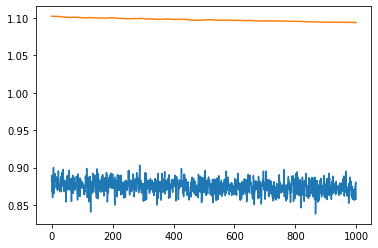

In [197]:
plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))

### Evaluate TeFF Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

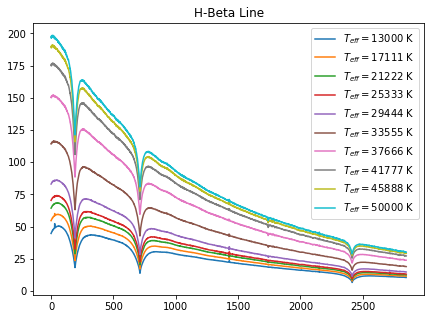

In [198]:
plt.figure(figsize=(7,5))
ts = np.linspace(13000,50000,10)
ls = np.linspace(8,8,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][100:3000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate logg Sensitivity

Text(0.5, 1.0, 'T = 35000 K')

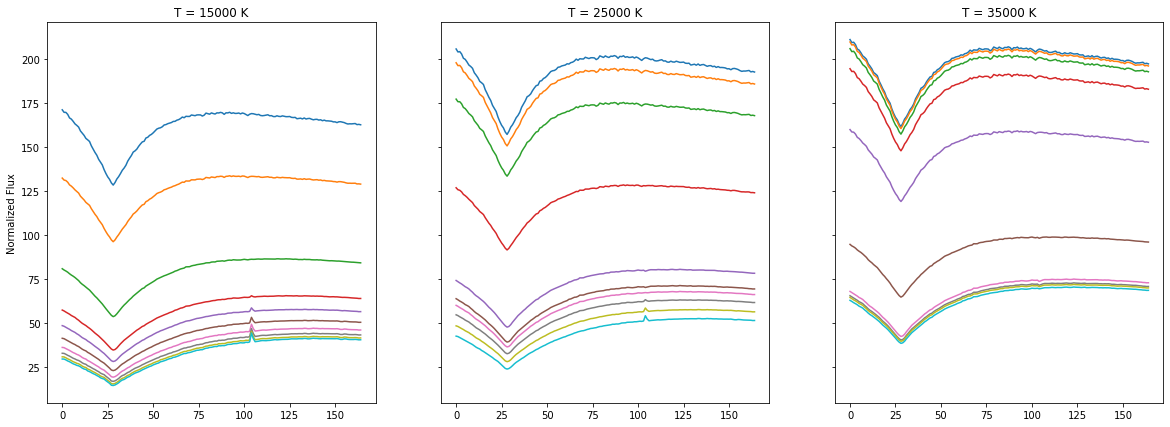

In [199]:
f,axs = plt.subplots(1,3,sharey = True,figsize=(20,7))

ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
for i in range(len(gens)):
    axs[0].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

#axs[0].legend(fontsize=8)
axs[0].set_title('T = 15000 K')
axs[0].set_ylabel('Normalized Flux')

ts = np.linspace(25000,25000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
for i in range(len(gens)):
    axs[1].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

#axs[1].legend(fontsize=8)
axs[1].set_title('T = 25000 K')

ts = np.linspace(35000,35000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
for i in range(len(gens)):
    axs[2].plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

#axs[2].legend(fontsize=6)
axs[2].set_title('T = 35000 K')

# plt.subplot(132)
# ts = np.linspace(25000,25000,10)
# ls = np.linspace(6.5,9.5,10)
# samples = sc.transform(np.stack((ts,ls)).transpose())
# gens = model.predict(samples)
# for i in range(len(gens)):
#     plt.plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

# plt.legend(fontsize=8)
# plt.title('T = 25000 K')

# plt.subplot(133)
# ts = np.linspace(35000,35000,10)
# ls = np.linspace(6.5,9.5,10)
# samples = sc.transform(np.stack((ts,ls)).transpose())
# gens = model.predict(samples)
# for i in range(len(gens)):
#     plt.plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

# plt.legend(fontsize=8)
# plt.title('T = 35000 K')

### Evaluate Residuals of Random Control Spectra

Text(0.5, 1.0, 'Sample of Model Residuals')

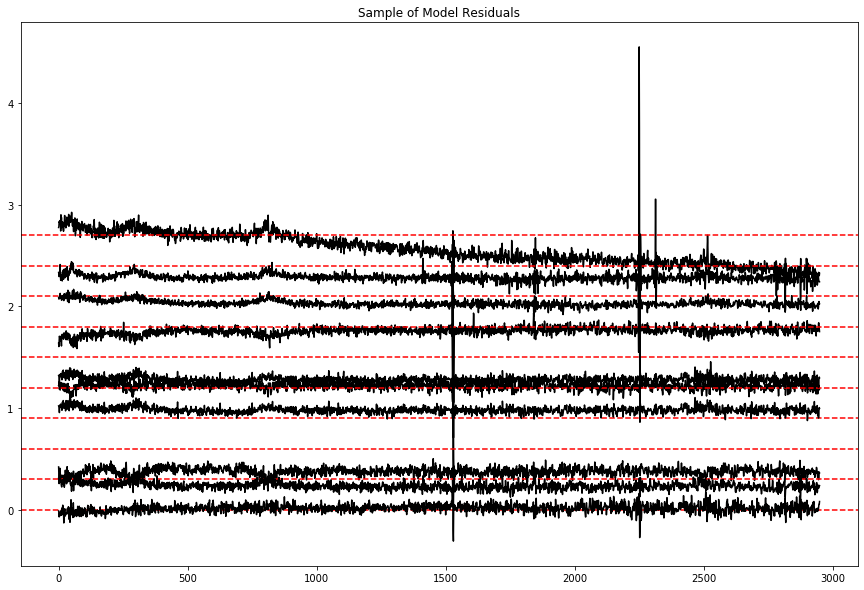

In [206]:
resids = y_test - model.predict(X_test)
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.3*ct,'k')
    plt.axhline(0.3*ct,color='r',linestyle='--')
    ct += 1
plt.title('Sample of Model Residuals')

In [208]:
modelscaling = 1

def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    return (interpolation.shift(msc.inverse_transform((model.predict(label)[0])),trans,cval=np.nan))*modelscaling

def chisquare(residual):
    return sum(residual**2)

In [218]:
lamgrid = np.arange(4050,7000)
fitter = lmfit.Model(spectrum_sampler)
params = fitter.make_params(teff = 20000.,logg=8.,trans=0.)
params['teff'].set(min=13000,max=50000,brute_step = 500)
params['logg'].set(min=6.5,max=9.5,brute_step = 0.1)
params['trans'].set(min=-3,max=3,brute_step = 1,vary = False)

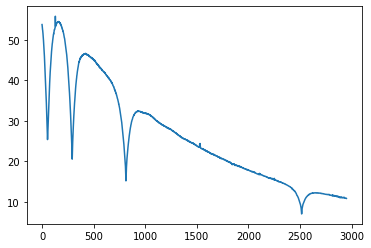

In [219]:
plt.plot(spectrum_sampler(None,15000,8.,0))










  0%|          | 0/152 [00:00<?, ?it/s]








  1%|          | 1/152 [00:02<05:47,  2.30s/it]








  1%|▏         | 2/152 [00:04<05:45,  2.30s/it]








  2%|▏         | 3/152 [00:06<05:43,  2.30s/it]

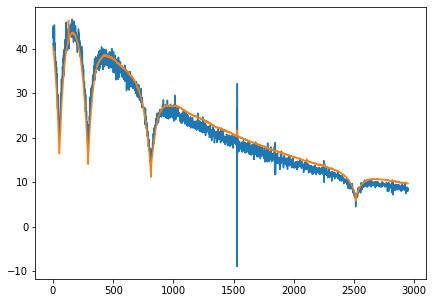










  3%|▎         | 4/152 [00:09<05:44,  2.33s/it]

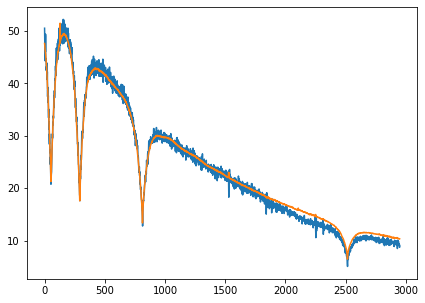










  3%|▎         | 5/152 [00:11<05:44,  2.34s/it]








  4%|▍         | 6/152 [00:13<05:37,  2.31s/it]








  5%|▍         | 7/152 [00:16<05:32,  2.29s/it]

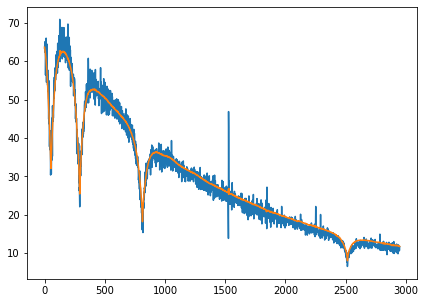










  5%|▌         | 8/152 [00:18<05:34,  2.32s/it]








  6%|▌         | 9/152 [00:20<05:28,  2.30s/it]








  7%|▋         | 10/152 [00:23<05:24,  2.29s/it]








  7%|▋         | 11/152 [00:25<05:20,  2.27s/it]








  8%|▊         | 12/152 [00:27<05:16,  2.26s/it]








  9%|▊         | 13/152 [00:29<05:13,  2.25s/it]

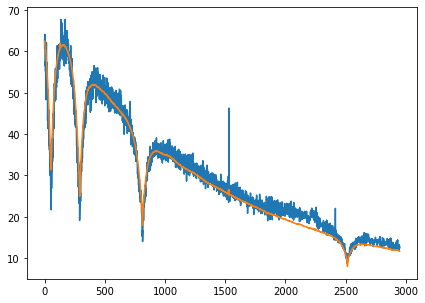










  9%|▉         | 14/152 [00:32<05:17,  2.30s/it]

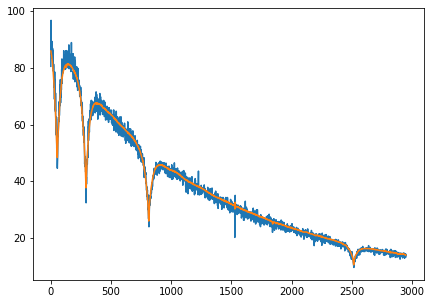










 10%|▉         | 15/152 [00:34<05:20,  2.34s/it]








 11%|█         | 16/152 [00:36<05:16,  2.33s/it]








 11%|█         | 17/152 [00:39<05:13,  2.32s/it]

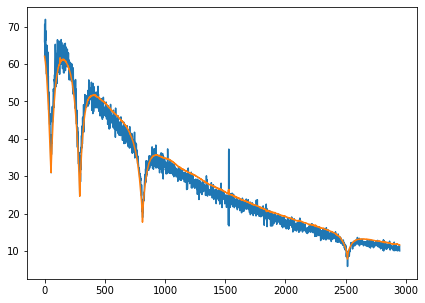










 12%|█▏        | 18/152 [00:41<05:15,  2.35s/it]








 12%|█▎        | 19/152 [00:43<05:12,  2.35s/it]








 13%|█▎        | 20/152 [00:46<05:07,  2.33s/it]








 14%|█▍        | 21/152 [00:48<05:03,  2.32s/it]








 14%|█▍        | 22/152 [00:50<05:00,  2.31s/it]

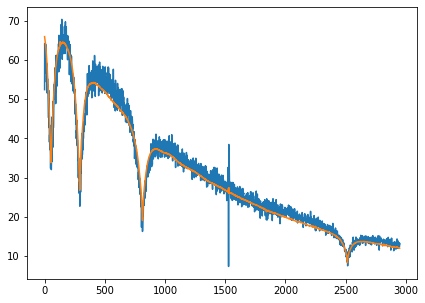










 15%|█▌        | 23/152 [00:53<05:03,  2.35s/it]








 16%|█▌        | 24/152 [00:55<04:59,  2.34s/it]








 16%|█▋        | 25/152 [00:57<04:55,  2.33s/it]

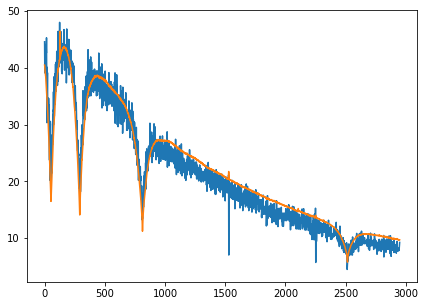










 17%|█▋        | 26/152 [01:00<04:57,  2.36s/it]








 18%|█▊        | 27/152 [01:02<04:50,  2.32s/it]

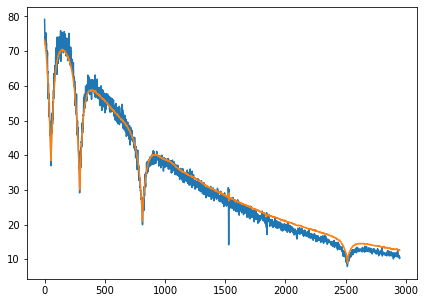










 18%|█▊        | 28/152 [01:05<05:07,  2.48s/it]

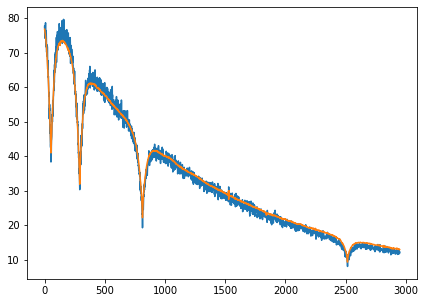










 19%|█▉        | 29/152 [01:07<05:01,  2.45s/it]








 20%|█▉        | 30/152 [01:10<04:51,  2.39s/it]








 20%|██        | 31/152 [01:12<04:44,  2.35s/it]








 21%|██        | 32/152 [01:14<04:41,  2.34s/it]








 22%|██▏       | 33/152 [01:16<04:35,  2.32s/it]








 22%|██▏       | 34/152 [01:19<04:31,  2.30s/it]

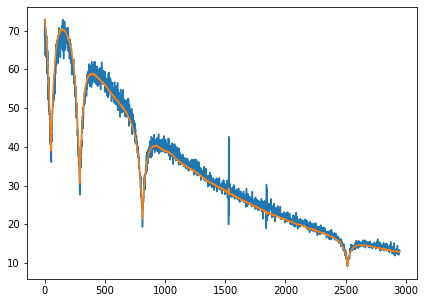










 23%|██▎       | 35/152 [01:21<04:33,  2.33s/it]








 24%|██▎       | 36/152 [01:23<04:27,  2.31s/it]

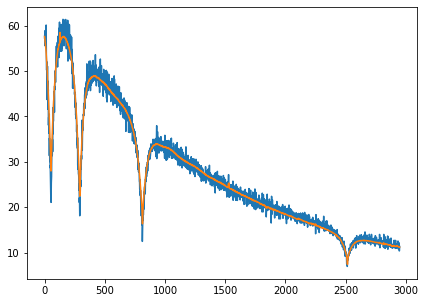










 24%|██▍       | 37/152 [01:26<04:27,  2.33s/it]








 25%|██▌       | 38/152 [01:28<04:23,  2.31s/it]








 26%|██▌       | 39/152 [01:31<04:35,  2.44s/it]








 26%|██▋       | 40/152 [01:34<04:57,  2.65s/it]








 27%|██▋       | 41/152 [01:37<05:10,  2.80s/it]








 28%|██▊       | 42/152 [01:40<05:17,  2.89s/it]








 28%|██▊       | 43/152 [01:43<05:10,  2.85s/it]








 29%|██▉       | 44/152 [01:45<04:48,  2.67s/it]








 30%|██▉       | 45/152 [01:47<04:33,  2.55s/it]








 30%|███       | 46/152 [01:50<04:24,  2.50s/it]

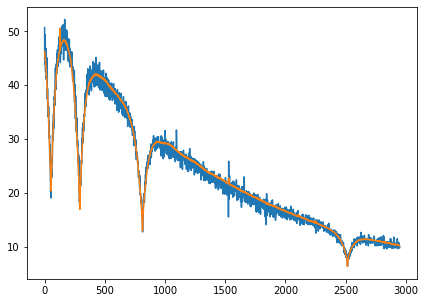










 31%|███       | 47/152 [01:52<04:19,  2.47s/it]








 32%|███▏      | 48/152 [01:54<04:11,  2.42s/it]








 32%|███▏      | 49/152 [01:57<04:08,  2.41s/it]








 33%|███▎      | 50/152 [01:59<04:11,  2.47s/it]








 34%|███▎      | 51/152 [02:02<04:04,  2.42s/it]








 34%|███▍      | 52/152 [02:04<03:57,  2.37s/it]

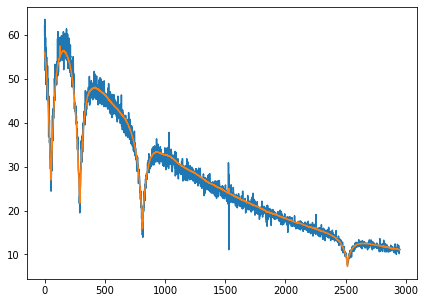










 35%|███▍      | 53/152 [02:06<03:54,  2.37s/it]

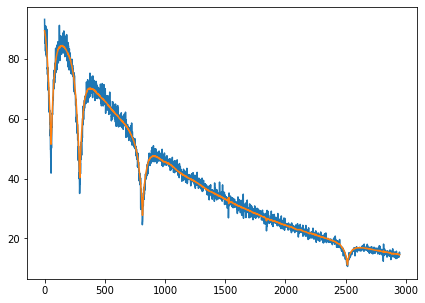










 36%|███▌      | 54/152 [02:09<03:52,  2.38s/it]








 36%|███▌      | 55/152 [02:11<03:46,  2.34s/it]








 37%|███▋      | 56/152 [02:13<03:42,  2.31s/it]








 38%|███▊      | 57/152 [02:16<03:37,  2.29s/it]








 38%|███▊      | 58/152 [02:18<03:34,  2.28s/it]








 39%|███▉      | 59/152 [02:20<03:31,  2.27s/it]








 39%|███▉      | 60/152 [02:22<03:27,  2.26s/it]

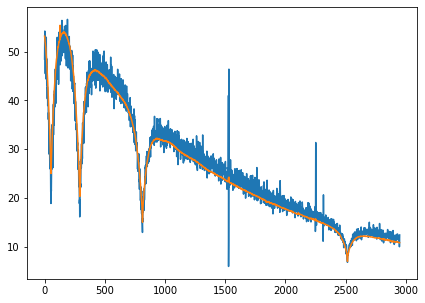










 40%|████      | 61/152 [02:25<03:28,  2.29s/it]








 41%|████      | 62/152 [02:27<03:24,  2.28s/it]








 41%|████▏     | 63/152 [02:29<03:21,  2.27s/it]








 42%|████▏     | 64/152 [02:31<03:18,  2.26s/it]

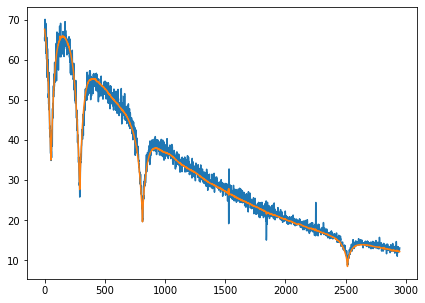










 43%|████▎     | 65/152 [02:34<03:19,  2.29s/it]








 43%|████▎     | 66/152 [02:36<03:15,  2.27s/it]








 44%|████▍     | 67/152 [02:38<03:12,  2.26s/it]

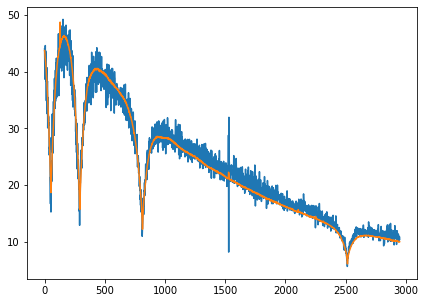










 45%|████▍     | 68/152 [02:41<03:12,  2.29s/it]








 45%|████▌     | 69/152 [02:43<03:08,  2.27s/it]








 46%|████▌     | 70/152 [02:45<03:05,  2.26s/it]








 47%|████▋     | 71/152 [02:47<03:02,  2.25s/it]

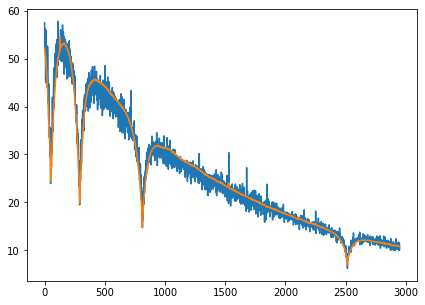










 47%|████▋     | 72/152 [02:50<03:03,  2.29s/it]

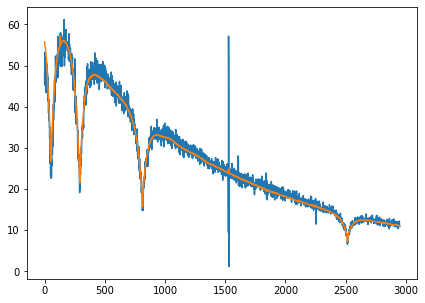










 48%|████▊     | 73/152 [02:52<03:03,  2.32s/it]

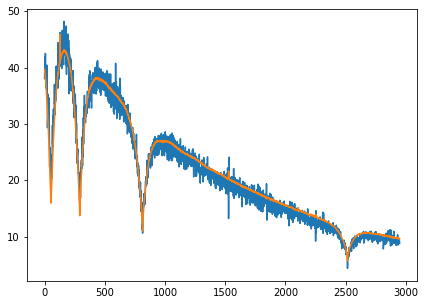










 49%|████▊     | 74/152 [02:54<03:01,  2.33s/it]








 49%|████▉     | 75/152 [02:57<02:57,  2.30s/it]








 50%|█████     | 76/152 [02:59<02:53,  2.28s/it]








 51%|█████     | 77/152 [03:01<02:49,  2.27s/it]

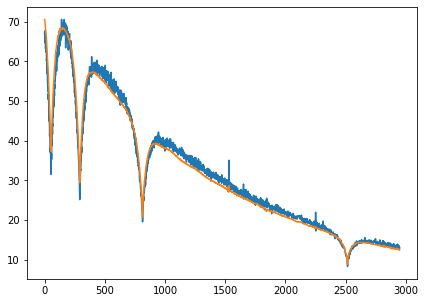










 51%|█████▏    | 78/152 [03:03<02:49,  2.30s/it]

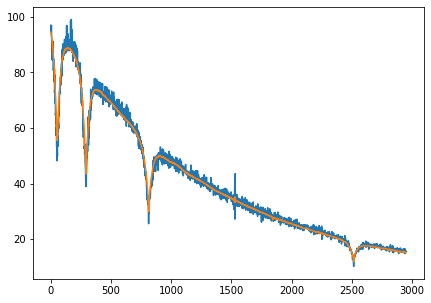










 52%|█████▏    | 79/152 [03:06<02:48,  2.31s/it]








 53%|█████▎    | 80/152 [03:08<02:44,  2.29s/it]








 53%|█████▎    | 81/152 [03:10<02:41,  2.27s/it]

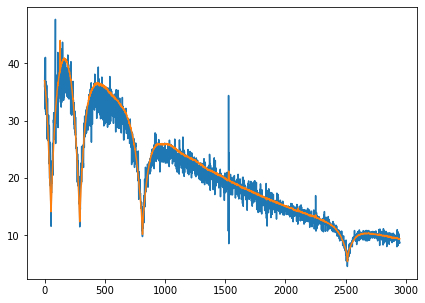










 54%|█████▍    | 82/152 [03:13<02:40,  2.29s/it]

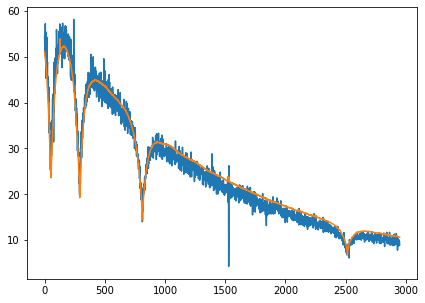










 55%|█████▍    | 83/152 [03:16<02:51,  2.48s/it]








 55%|█████▌    | 84/152 [03:18<02:43,  2.41s/it]

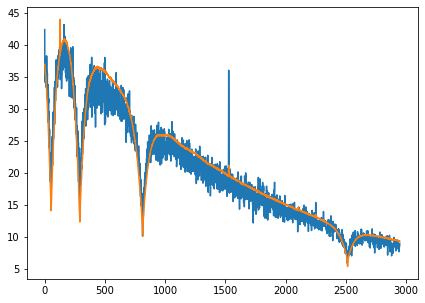










 56%|█████▌    | 85/152 [03:20<02:40,  2.40s/it]








 57%|█████▋    | 86/152 [03:22<02:34,  2.35s/it]

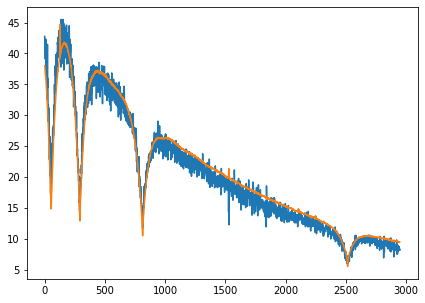










 57%|█████▋    | 87/152 [03:25<02:32,  2.35s/it]








 58%|█████▊    | 88/152 [03:27<02:28,  2.32s/it]








 59%|█████▊    | 89/152 [03:29<02:25,  2.31s/it]








 59%|█████▉    | 90/152 [03:31<02:22,  2.29s/it]








 60%|█████▉    | 91/152 [03:34<02:18,  2.28s/it]








 61%|██████    | 92/152 [03:36<02:15,  2.27s/it]








 61%|██████    | 93/152 [03:38<02:13,  2.26s/it]








 62%|██████▏   | 94/152 [03:40<02:10,  2.25s/it]








 62%|██████▎   | 95/152 [03:43<02:08,  2.25s/it]








 63%|██████▎   | 96/152 [03:45<02:05,  2.24s/it]








 64%|██████▍   | 97/152 [03:47<02:03,  2.24s/it]








 64%|██████▍   | 98/152 [03:49<02:00,  2.24s/it]








 65%|██████▌   | 99/152 [03:52<01:58,  2.23s/it]








 66%|██████▌   | 100/152 [03:54<01:56,  2.24s/it]

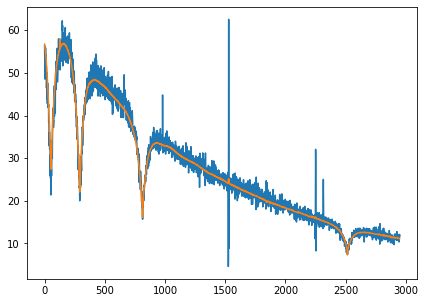










 66%|██████▋   | 101/152 [03:56<01:55,  2.27s/it]








 67%|██████▋   | 102/152 [03:58<01:53,  2.26s/it]








 68%|██████▊   | 103/152 [04:01<01:50,  2.25s/it]








 68%|██████▊   | 104/152 [04:03<01:48,  2.25s/it]








 69%|██████▉   | 105/152 [04:05<01:45,  2.24s/it]








 70%|██████▉   | 106/152 [04:07<01:43,  2.24s/it]








 70%|███████   | 107/152 [04:10<01:40,  2.24s/it]








 71%|███████   | 108/152 [04:12<01:38,  2.24s/it]








 72%|███████▏  | 109/152 [04:14<01:36,  2.24s/it]








 72%|███████▏  | 110/152 [04:16<01:33,  2.23s/it]

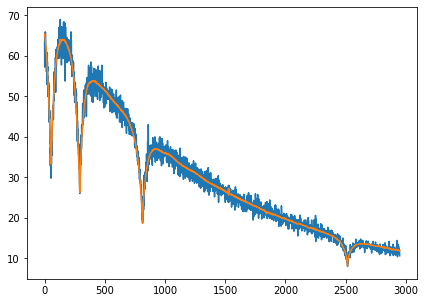










 73%|███████▎  | 111/152 [04:19<01:33,  2.27s/it]








 74%|███████▎  | 112/152 [04:21<01:30,  2.26s/it]








 74%|███████▍  | 113/152 [04:23<01:27,  2.25s/it]








 75%|███████▌  | 114/152 [04:25<01:25,  2.25s/it]








 76%|███████▌  | 115/152 [04:28<01:22,  2.24s/it]








 76%|███████▋  | 116/152 [04:30<01:20,  2.24s/it]

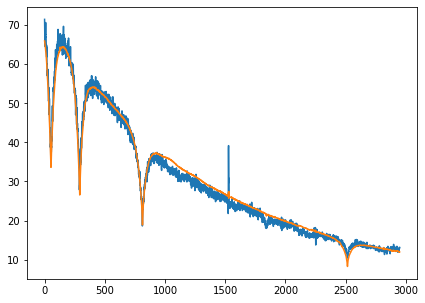










 77%|███████▋  | 117/152 [04:32<01:19,  2.28s/it]

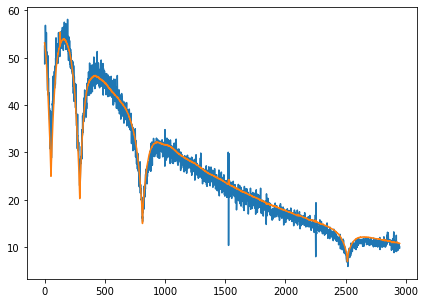










 78%|███████▊  | 118/152 [04:35<01:18,  2.31s/it]

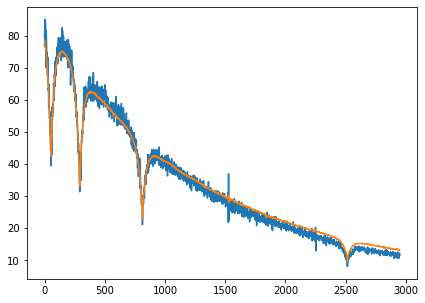










 78%|███████▊  | 119/152 [04:37<01:16,  2.33s/it]








 79%|███████▉  | 120/152 [04:39<01:13,  2.30s/it]








 80%|███████▉  | 121/152 [04:41<01:10,  2.28s/it]








 80%|████████  | 122/152 [04:44<01:07,  2.27s/it]








 81%|████████  | 123/152 [04:46<01:05,  2.26s/it]








 82%|████████▏ | 124/152 [04:48<01:02,  2.25s/it]








 82%|████████▏ | 125/152 [04:50<01:00,  2.25s/it]

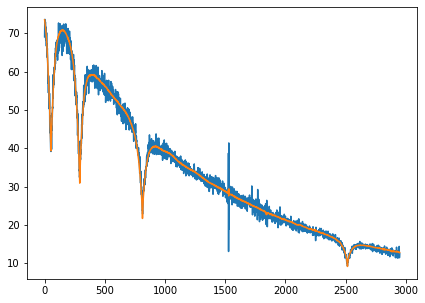










 83%|████████▎ | 126/152 [04:53<00:59,  2.29s/it]

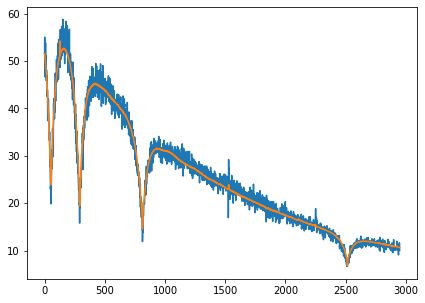










 84%|████████▎ | 127/152 [04:55<00:57,  2.31s/it]








 84%|████████▍ | 128/152 [04:57<00:54,  2.29s/it]








 85%|████████▍ | 129/152 [05:00<00:52,  2.27s/it]








 86%|████████▌ | 130/152 [05:02<00:49,  2.26s/it]








 86%|████████▌ | 131/152 [05:04<00:47,  2.25s/it]








 87%|████████▋ | 132/152 [05:06<00:44,  2.25s/it]

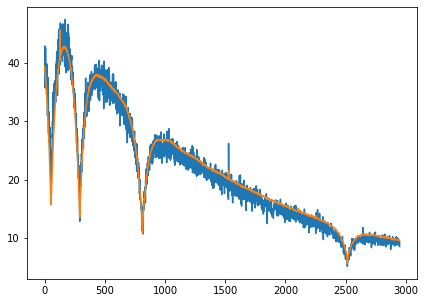










 88%|████████▊ | 133/152 [05:09<00:43,  2.28s/it]








 88%|████████▊ | 134/152 [05:11<00:40,  2.27s/it]








 89%|████████▉ | 135/152 [05:13<00:38,  2.26s/it]








 89%|████████▉ | 136/152 [05:15<00:35,  2.25s/it]








 90%|█████████ | 137/152 [05:18<00:33,  2.24s/it]








 91%|█████████ | 138/152 [05:20<00:31,  2.24s/it]








 91%|█████████▏| 139/152 [05:22<00:29,  2.26s/it]








 92%|█████████▏| 140/152 [05:25<00:28,  2.39s/it]








 93%|█████████▎| 141/152 [05:27<00:25,  2.35s/it]








 93%|█████████▎| 142/152 [05:29<00:23,  2.32s/it]








 94%|█████████▍| 143/152 [05:32<00:20,  2.30s/it]








 95%|█████████▍| 144/152 [05:34<00:18,  2.28s/it]








 95%|█████████▌| 145/152 [05:36<00:15,  2.27s/it]








 96%|█████████▌| 146/152 [05:38<00:13,  2.27s/it]








 97%|█████████▋| 147/152 [05:41<00:11,  2.27s/it]

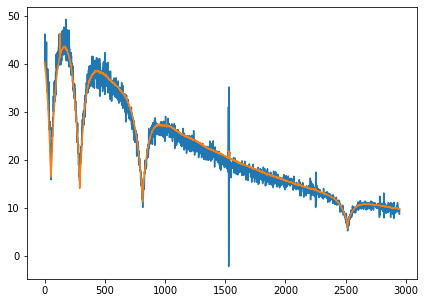










 97%|█████████▋| 148/152 [05:43<00:09,  2.30s/it]








 98%|█████████▊| 149/152 [05:45<00:06,  2.29s/it]








 99%|█████████▊| 150/152 [05:47<00:04,  2.28s/it]








 99%|█████████▉| 151/152 [05:50<00:02,  2.27s/it]








100%|██████████| 152/152 [05:52<00:00,  2.26s/it]

In [220]:
fitoutput = np.zeros((len(y_test),5))

for i in tqdm(range(len(y_test))):
    spec = msc.inverse_transform(y_test[i])
    fitoutput[i,0] = int(specnames[i][:-12])
    #params['teff'].set(value=sc.inverse_transform(X_test)[i,0],vary=False)
    result = fitter.fit(spec*modelscaling,params,wl=lamgrid,method="brute",nan_policy='omit',calc_covar=True)
    if result.redchi > 5:
        continue;
    fitoutput[i,1] = result.params['teff'].value
    fitoutput[i,2] = result.params['teff'].stderr
    fitoutput[i,3] = result.params['logg'].value
    fitoutput[i,4] = result.params['logg'].stderr
    
    plt.figure(figsize=(7,5))
    plt.plot(spec*modelscaling)
    plt.plot(spectrum_sampler(None,result.params['teff'],result.params['logg'],result.params['trans']))
    plt.show()

In [221]:
true_labels = sc.inverse_transform(X_test)

Text(0.5, 1.0, 'Data-Driven Generator')

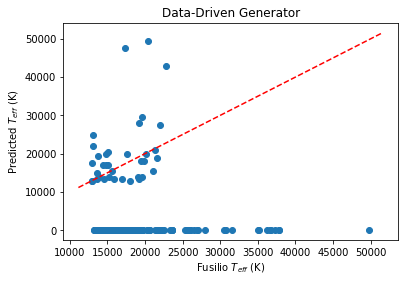

In [226]:
true = true_labels[:,0]
pred = fitoutput[:,1]
f=plt.scatter(true,pred)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Data-Driven Generator')

Text(0.5, 1.0, 'Data-Driven Generator')

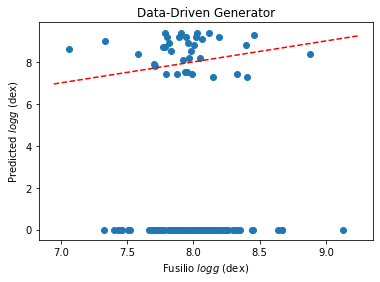

In [223]:
true = true_labels[:,1]
pred = fitoutput[:,3]
f=plt.scatter(true,pred)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $logg$ (dex)')
plt.ylabel('Predicted $logg$ (dex)')
plt.title('Data-Driven Generator')

In [227]:
mask = pred != 0

In [228]:
np.sqrt(sum((pred[mask]-true[mask])**2)/len(pred[mask]))

8981.494778505872